**Imagehash** を使って Train と Test のデータに重複がないかを確認しました。  
類似した画像は Train/Test のどちらか一方だけに含まれることが多かったが、一部 Train と Test で分かれているものもありました（人の目には似てないように見えるものも多々ありますが）。何かの参考になれば幸いです。  


- 参考にしたノートブック: https://www.kaggle.com/appian/let-s-find-out-duplicate-images-with-imagehash

In [1]:
# !pip install imagehash > /dev/null

In [2]:
import os
from dataclasses import dataclass
from typing import *

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image


%matplotlib inline
sns.set_style("whitegrid")

In [3]:
from dataclasses import dataclass


@dataclass
class InputPath:
    _prefix: str = "../input"
    train_images: str = f"{_prefix}/christ-train-imgs.npz"
    train_labels: str = f"{_prefix}/christ-train-labels.npz"
    test_images: str = f"{_prefix}/christ-test-imgs.npz"
        
        
def load_npz(path: str) -> np.array:
    return np.load(path)["arr_0"]

### Imagehash

In [4]:
import torch
import imagehash
from tqdm import tqdm


def run_imagehash(arr: np.array) -> Tuple[List[str], np.array]:
    funcs = [
        imagehash.average_hash,
        imagehash.phash,
        imagehash.dhash,
        imagehash.whash,
    ]
    image_indices: List[str] = []
    hashes: List[np.array] = []
    for i, elem in tqdm(enumerate(arr), total=len(arr)):
        image = Image.fromarray(np.uint8(elem))
        hashes.append(np.array([f(image).hash for f in funcs]).reshape(256))
        image_indices.append(i)
    return image_indices, np.array(hashes)


train = load_npz(InputPath.train_images)
test = load_npz(InputPath.test_images)
train_labels = load_npz(InputPath.train_labels)
train_length = len(train)
train_test = np.concatenate((train, test))

%time image_indices, hashes_all = run_imagehash(train_test)

100%|██████████| 1151/1151 [00:03<00:00, 297.53it/s]

CPU times: user 3.72 s, sys: 0 ns, total: 3.72 s
Wall time: 3.87 s


In [5]:
hashes_all = torch.Tensor(hashes_all.astype(int)).cuda()
sims = np.array([(hashes_all[i] == hashes_all).sum(dim=1).cpu().numpy()/256 for i in range(hashes_all.shape[0])])

In [10]:
threhold = 0.88

indices1 = np.where(sims > threhold)
indices2 = np.where(indices1[0] != indices1[1])
object_ids1 = [image_indices[i] for i in indices1[0][indices2]]
object_ids2 = [image_indices[i] for i in indices1[1][indices2]]
dups = {tuple(sorted([object_id1, object_id2])):True for object_id1, object_id2 in zip(object_ids1, object_ids2)}
print(f'found {len(dups)} duplicates')

found 28 duplicates


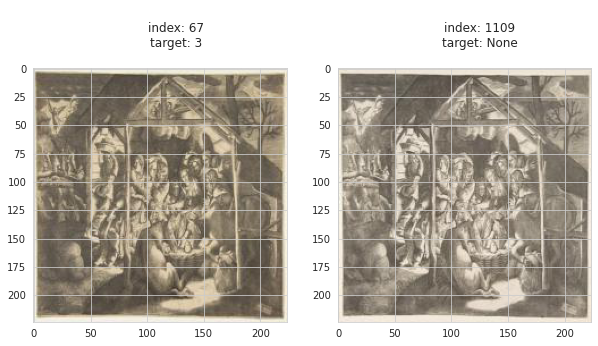

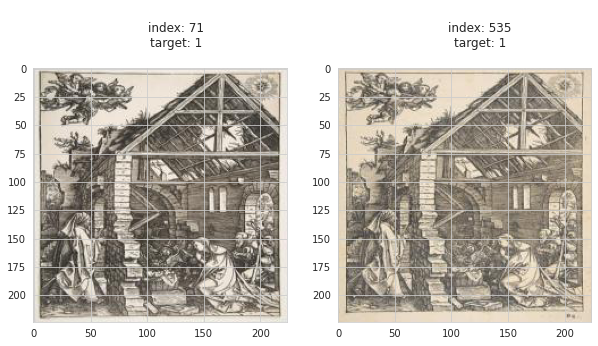

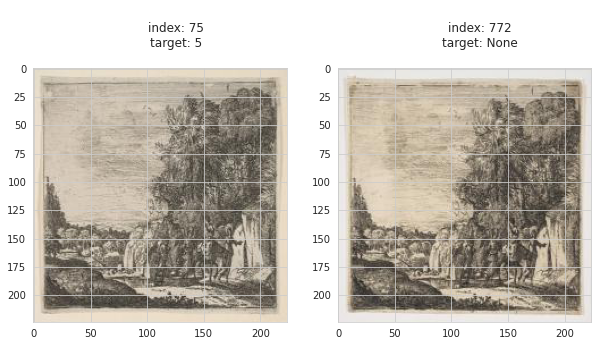

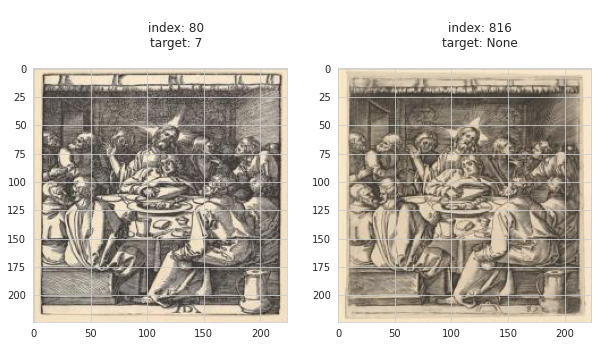

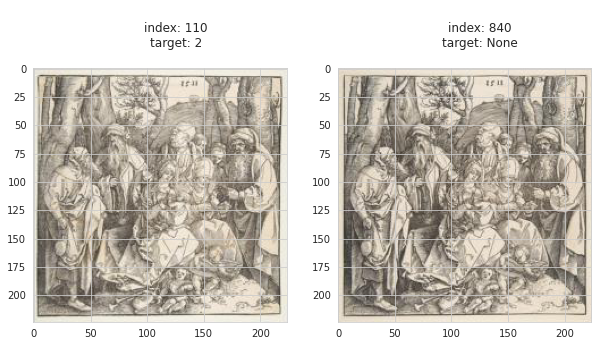

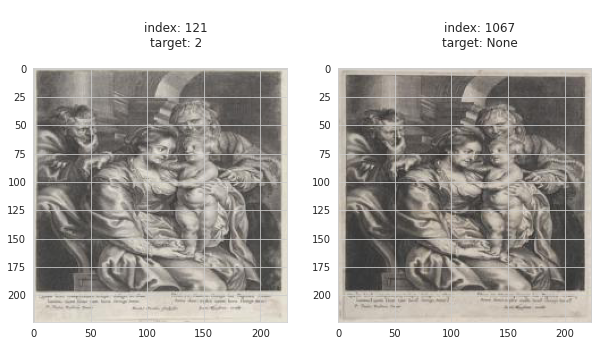

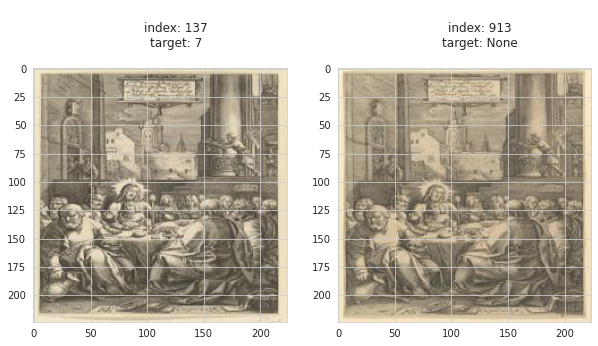

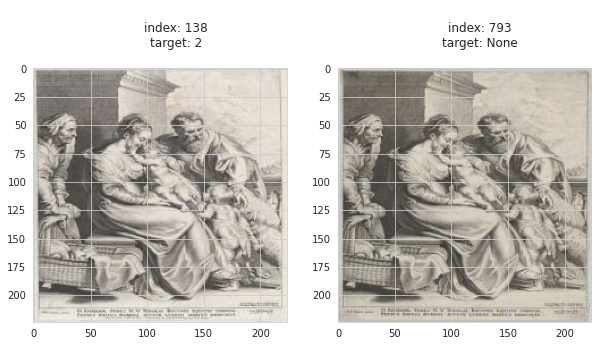

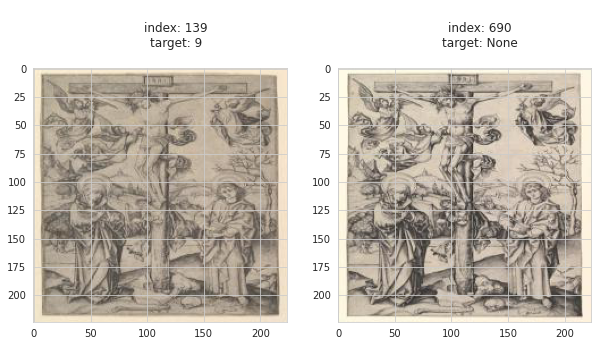

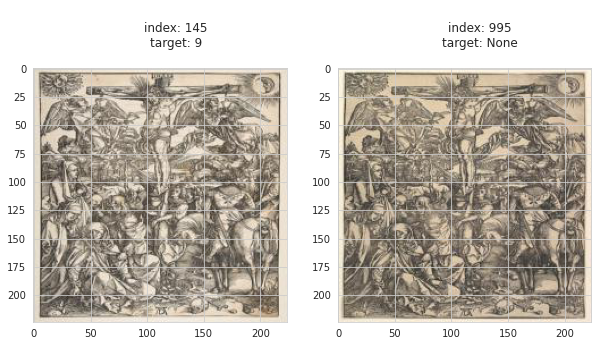

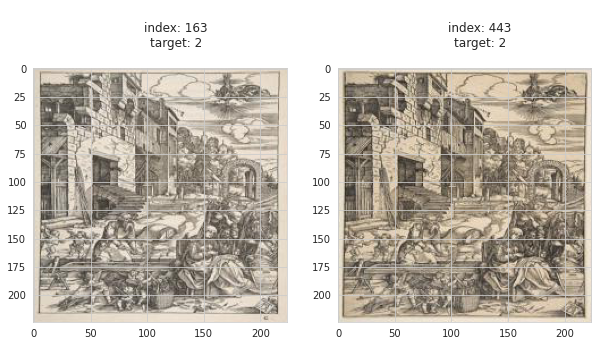

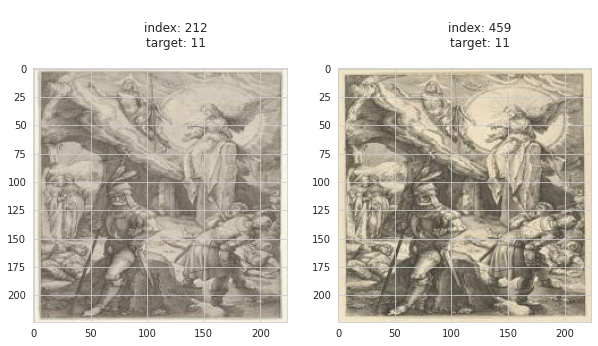

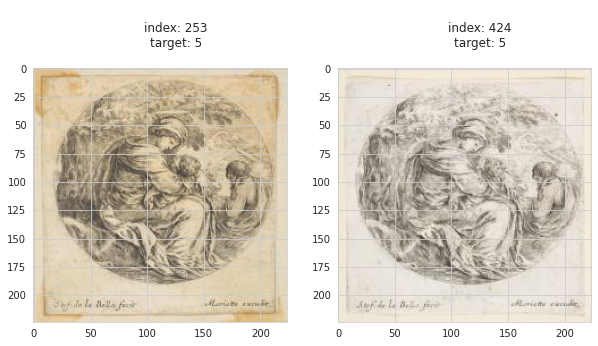

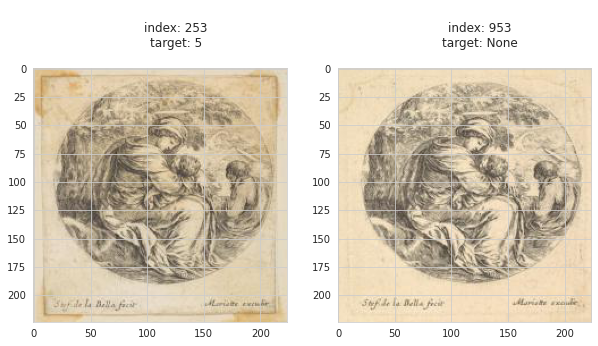

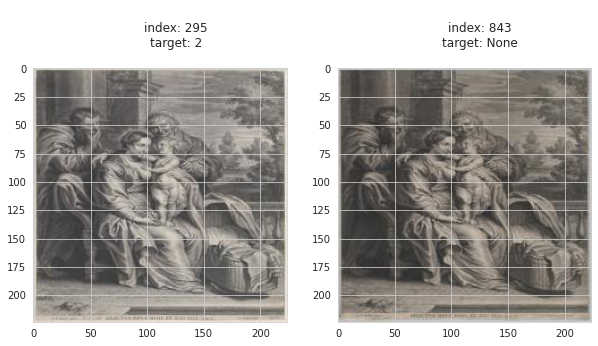

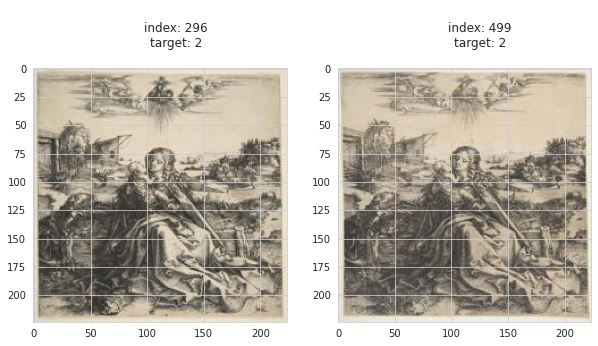

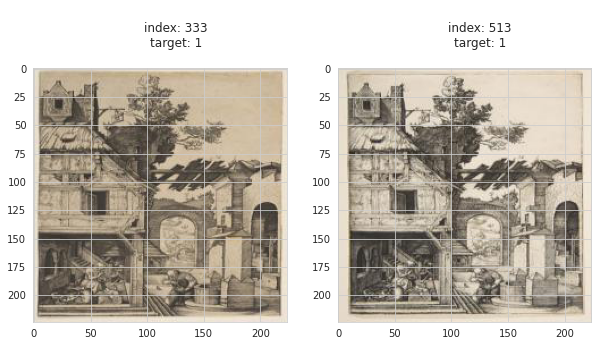

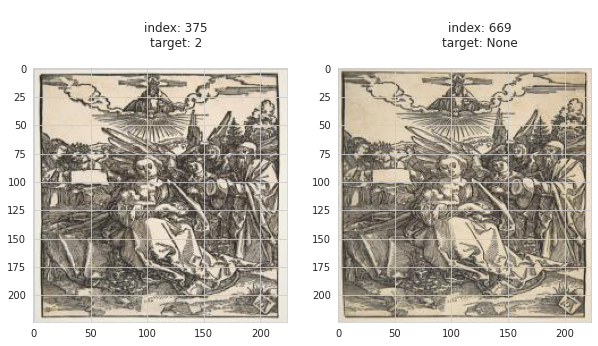

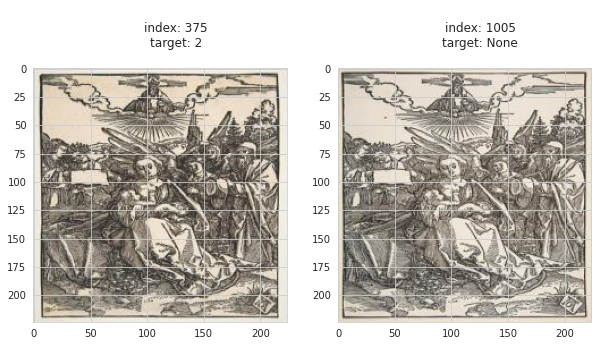

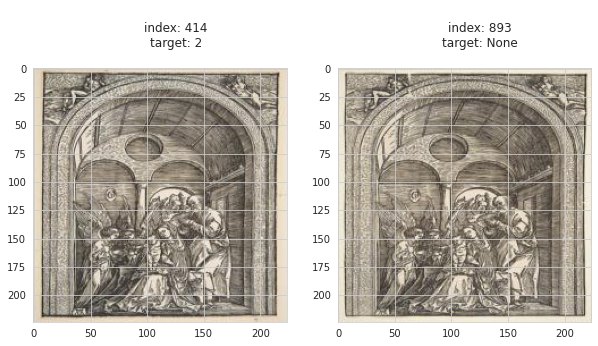

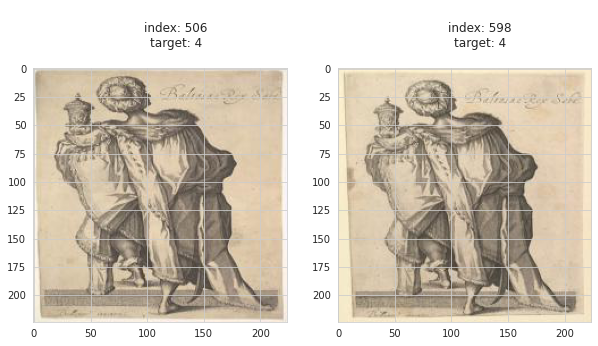

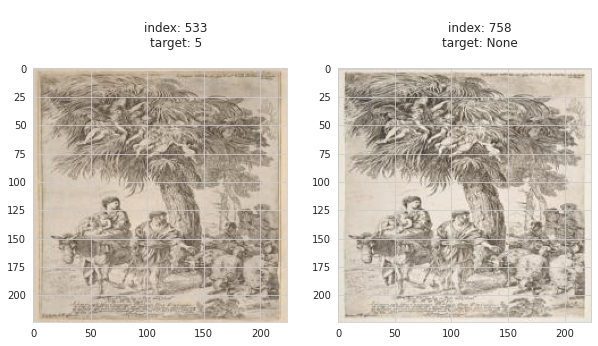

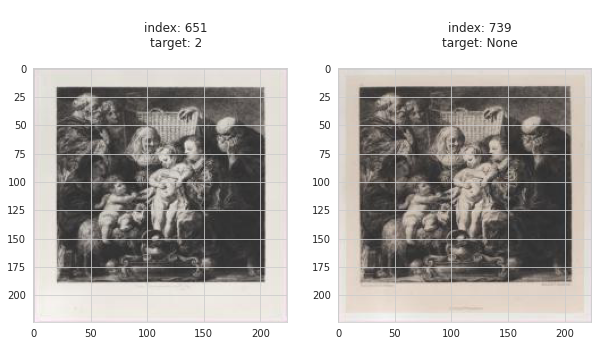

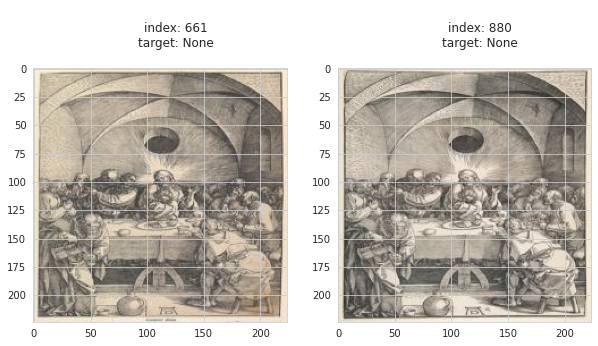

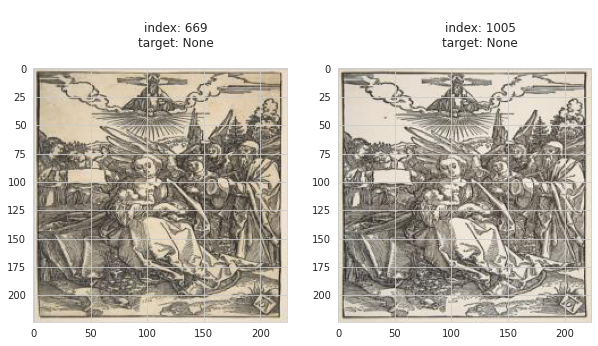

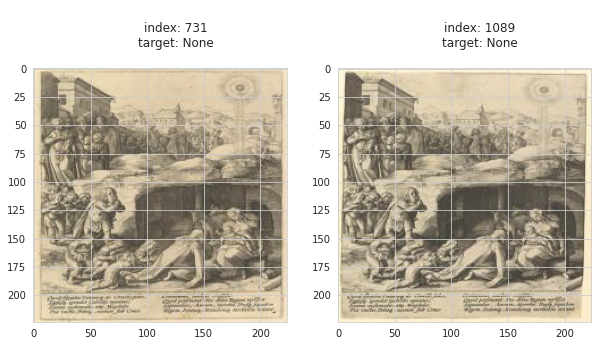

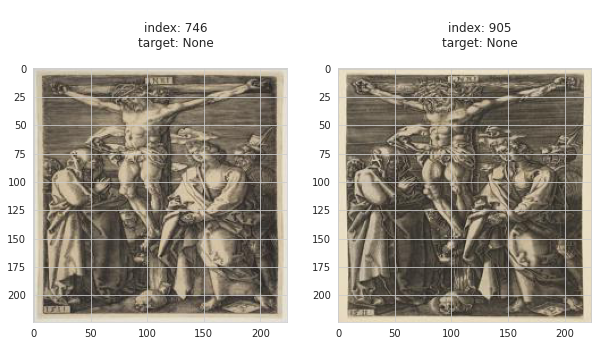

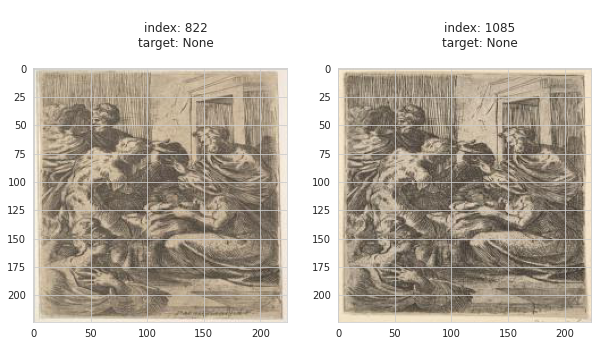

In [11]:
for image_index1, image_index2 in sorted(list(dups)):
    image1 = train_test[image_index1]
    image2 = train_test[image_index2]
    target1 = train_labels[image_index1] if image_index1 < train_length else None
    target2 = train_labels[image_index2] if image_index2 < train_length else None
    
    fig = plt.figure(figsize=(10, 20))
    fig.add_subplot(1,2,1)
    plt.title(f"""
        index: {image_index1}
        target: {target1}
    """)
    plt.imshow(image1)
    fig.add_subplot(1,2,2)
    plt.title(f"""
        index: {image_index2}
        target: {target2}
    """)
    plt.imshow(image2)
    plt.show()

In [27]:
duplicate_image_target_dict: Dict[int, int] = {}
for image_index1, image_index2 in sorted(list(dups)):
    assert image_index1 < image_index2
    target1 = train_labels[image_index1] if image_index1 < train_length else None
    target2 = train_labels[image_index2] if image_index2 < train_length else None
    if target1 is not None and target2 is None:
        duplicate_image_target_dict[image_index2] = target1
        
duplicate_image_target_dict

{1109: 3,
 772: 5,
 816: 7,
 840: 2,
 1067: 2,
 913: 7,
 793: 2,
 690: 9,
 995: 9,
 953: 5,
 843: 2,
 669: 2,
 1005: 2,
 893: 2,
 758: 5,
 739: 2}

In [28]:
import sys
sys.path.append("..")


from src.utils import Jbl
Jbl.save(duplicate_image_target_dict, "../output/duplicate_image_target_dict.jbl")